# Analyze generic genes and pathways

This notebook uses the DEG and GSEA statistics obtained from the previous notebooks [3_gene_DE_analysis](3_gene_DE_analysis.ipynb) and [4_pathway enrichment analysis](4_pathway_enrichment_analysis.ipynb) to: 
1. Determine if our simulation approach can identify a set of generic genes and pathways
2. Compare our set of generic genes and pathways with what has been previously reported

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pickle
import pandas as pd
import numpy as np
import random
import warnings
import rpy2.robjects
import seaborn as sns
from scipy import stats

from plotnine import (ggplot,
                      labs,   
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
col_to_rank = params['col_to_rank']

In [4]:
# Input files
gene_summary_file = os.path.join(
    local_dir, 
    "gene_summary_table_"+col_to_rank+".tsv")

pathway_summary_file = os.path.join(
    local_dir, 
    "pathway_summary_table_"+col_to_rank+".tsv")

## Generic genes
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. We want to compare the ability to detect these generic genes using our method vs those found by Crow et. al.

### Map gene ids
Our gene ids are ensembl while the published gene ids are using hgnc symbols. We need to map ensembl to hgnc ids in order to compare results.

In [5]:
#%%R
#suppressWarnings(library("biomaRt"))

In [6]:
#%%R -i gene_summary_file -o gene_id_mapping
# Convert gene ids from ensembl (ours) to entrez (DE_prior)

#source('../functions/GSEA_analysis.R')

#gene_id_mapping <- get_ensembl_symbol_mapping(gene_summary_file)

In [7]:
# Set ensembl id as index
#gene_id_mapping.set_index("ensembl_gene_id", inplace=True)
#print(gene_id_mapping.shape)
#gene_id_mapping.head()

In [8]:
# Save 
#gene_id_file = os.path.join(
#    local_dir,
#    "ensembl_hgnc_mapping.tsv")
#gene_id_mapping.to_csv(gene_id_file, float_format='%.5f', sep='\t')

In [9]:
# Read data
gene_stats = pd.read_csv(
    gene_summary_file,
    header=0,
    sep='\t',
    index_col=0)

print(gene_stats.shape)
sample_gene_id = gene_stats.index[0].split(".")[0]
gene_stats.head()

(17810, 10)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IGHG1,ENSG00000211896.7,0.03446,17809.0,4217.28509,0.00280,17796.0,241.24924,292.11299,25,13.61129
SCGB3A1,ENSG00000161055.3,0.10740,17807.0,2953.13558,0.04015,17678.0,85.64603,145.96075,25,19.64562
CEACAM6,ENSG00000086548.8,0.00175,17806.0,682.86373,0.00076,17768.0,81.22895,93.15353,25,6.45853
IGLL5,ENSG00000254709.7,0.01063,17804.0,605.22586,0.00484,17068.0,38.42943,88.16046,25,6.42915
COL1A1,ENSG00000108821.13,0.03039,17798.0,372.52724,0.00092,17586.0,-25.24062,45.49906,25,8.74233


In [10]:
# Read file mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

gene_id_mapping = pd.read_csv(
    gene_id_file,
    header=0,
    sep='\t',
    index_col=0)

gene_id_mapping.set_index("ensembl_gene_id", inplace=True)
gene_id_mapping.head()

,hgnc_symbol
ensembl_gene_id,
ENSG00000002330,BAD
ENSG00000003137,CYP26B1
ENSG00000003249,DBNDD1
ENSG00000004799,PDK4
ENSG00000006062,MAP3K14


In [11]:
# Replace ensembl ids with gene symbols
# Only replace if ensembl ids exist
if sample_gene_id in list(gene_id_mapping.index):
    print("replacing ensembl ids")
    utils.replace_ensembl_ids(gene_summary_file,
                              gene_id_mapping)

### Our DEGs
Genes are ranked by their adjusted p-value and the median rank reported across 25 simulated experiments is shown in column `Rank (simulated)`.

In [12]:
# Read data back after renaming gene ids
gene_stats = pd.read_csv(
    gene_summary_file,
    header=0,
    sep='\t',
    index_col=0)

gene_stats.head()

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IGHG1,ENSG00000211896.7,0.03446,17809.0,4217.28509,0.00280,17796.0,241.24924,292.11299,25,13.61129
SCGB3A1,ENSG00000161055.3,0.10740,17807.0,2953.13558,0.04015,17678.0,85.64603,145.96075,25,19.64562
CEACAM6,ENSG00000086548.8,0.00175,17806.0,682.86373,0.00076,17768.0,81.22895,93.15353,25,6.45853
IGLL5,ENSG00000254709.7,0.01063,17804.0,605.22586,0.00484,17068.0,38.42943,88.16046,25,6.42915
COL1A1,ENSG00000108821.13,0.03039,17798.0,372.52724,0.00092,17586.0,-25.24062,45.49906,25,8.74233


In [13]:
# Get list of our genes
gene_ids = list(gene_stats.index)

### Published DEGs
These DEGs are based on the [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

In [14]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [15]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

### Compare DEG ranks

In [16]:
# Get intersection of gene lists
shared_genes = set(gene_ids).intersection(published_generic_genes)
print(len(shared_genes))

17787


In [17]:
# Load shared genes
#shared_genes_file = os.path.join(
#    local_dir,
#    "shared_gene_ids.pickle")

#shared_genes = pickle.load(open(shared_genes_file, "rb" ))
#print(len(shared_genes))

In [18]:
# check that all our genes are a subset of the published ones, no genes unique to ours

In [20]:
# Get rank of shared genes
our_gene_rank_df = pd.DataFrame(gene_stats.loc[shared_genes,'Rank (simulated)'])
print(our_gene_rank_df.shape)
our_gene_rank_df.head()

(17810, 1)


,Rank (simulated)
LINC00330,1568.0
SGIP1,8416.0
GRK6,9173.5
AVPI1,5092.5
FAM114A2,5946.5


In [21]:
# Merge published ranking
shared_gene_rank_df = pd.merge(our_gene_rank_df,
                                        DE_prior[['DE_Prior_Rank','Gene_Name']],
                                        left_index=True,
                                        right_on='Gene_Name')

shared_gene_rank_df.set_index('Gene_Name', inplace=True)
print(shared_gene_rank_df.shape)
shared_gene_rank_df.head()

(17810, 2)


,Rank (simulated),DE_Prior_Rank
Gene_Name,,
LINC00330,1568.0,0.075083
SGIP1,8416.0,0.823232
GRK6,9173.5,0.744106
AVPI1,5092.5,0.725537
FAM114A2,5946.5,0.237482


In [22]:
# Scale published ranking to our range
max_rank = max(shared_gene_rank_df['Rank (simulated)'])
shared_gene_rank_df['DE_Prior_Rank'] = round(shared_gene_rank_df['DE_Prior_Rank']*max_rank)
shared_gene_rank_df.head()

,Rank (simulated),DE_Prior_Rank
Gene_Name,,
LINC00330,1568.0,1337.0
SGIP1,8416.0,14662.0
GRK6,9173.5,13253.0
AVPI1,5092.5,12922.0
FAM114A2,5946.5,4230.0


In [23]:
# Get top ranked genes by both methods
#shared_gene_rank_df[(shared_gene_rank_df['Rank (simulated)']>17500) & (shared_gene_rank_df['DE_Prior_Rank']>17500)]

In [24]:
# Get low ranked genes by both methods
#shared_gene_rank_df[(shared_gene_rank_df['Rank (simulated)']<300) & (shared_gene_rank_df['DE_Prior_Rank']<300)]

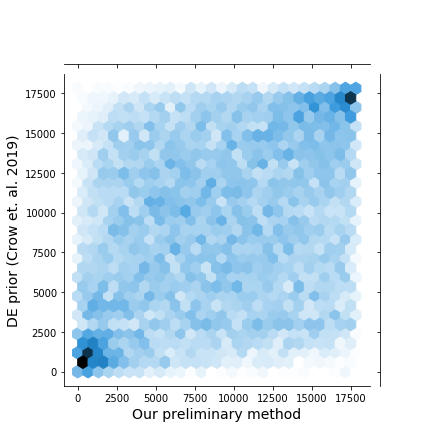

In [25]:
# Plot our ranking vs published ranking
fig_file = os.path.join(
    local_dir, 
    "gene_ranking_"+col_to_rank+".svg")

fig = sns.jointplot(data=shared_gene_rank_df,
                    x='Rank (simulated)',
                    y='DE_Prior_Rank',
                    kind='hex',
                    marginal_kws={'color':'white'})
fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

fig.savefig(fig_file,
            format='svg',
            bbox_inches="tight",
            transparent=True,
            pad_inches=0,
            dpi=300,)

### Calculate correlation

In [26]:
# Get correlation
r, p, ci_high, ci_low = utils.spearman_ci(shared_gene_rank_df,
                                         1000)

print(r, p, ci_high, ci_low)

0.29211340346860176 0.0 0.2784594474268234 0.30644585840520416


## Generic pathways

In [27]:
"""
# Read data
pathway_stats = pd.read_csv(
    pathway_summary_file,
    header=0,
    sep='\t',
    index_col=0)

pathway_stats.head()"""

"\n# Read data\npathway_stats = pd.read_csv(\n    pathway_summary_file,\n    header=0,\n    sep='\t',\n    index_col=0)\n\npathway_stats.head()"

In [28]:
"""# Define what are the set of generic genes
generic_pathway_data = pathway_stats.sort_values(by="Z score", ascending=True)[0:10]

generic_pathway_data.head()"""

'# Define what are the set of generic genes\ngeneric_pathway_data = pathway_stats.sort_values(by="Z score", ascending=True)[0:10]\n\ngeneric_pathway_data.head()'

In [29]:
# Manually compare against Powers et. al publication 
# https://academic.oup.com/bioinformatics/article/34/13/i555/5045793